In [1]:
import os
from collections import OrderedDict
from glob import glob
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
import albumentations as A
from albumentations.core.composition import Compose
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

In [2]:
import archs
import losses
from dataset import Dataset
from metrics import iou_score
from utils import AverageMeter

In [3]:
plt.style.use('default')

print("✅ Librerías importadas correctamente")
print(f"🔥 CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔥 GPU: {torch.cuda.get_device_name(0)}")

✅ Librerías importadas correctamente
🔥 CUDA disponible: True
🔥 GPU: NVIDIA GeForce RTX 4060


In [4]:
class LabelSmoothingBCELoss(nn.Module):
  def __init__(self, smoothing=0.05):
    super().__init__()
    self.smoothing = smoothing
      
  def forward(self, pred, target):
    target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
    return F.binary_cross_entropy(pred, target_smooth)

In [5]:
class BinaryDiceLoss(nn.Module):
  def __init__(self, smooth=1.0):
    super().__init__()
    self.smooth = smooth
      
  def forward(self, pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
    
    return 1 - dice

In [6]:
class TverskyLoss(nn.Module):
  def __init__(self, alpha=0.3, beta=0.7, smooth=1):
    super().__init__()
    self.alpha = alpha
    self.beta = beta
    self.smooth = smooth

  def forward(self, pred, target):
    pred = torch.sigmoid(pred)  # aseguramos probabilidades
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    TP = (pred_flat * target_flat).sum()
    FP = ((1 - target_flat) * pred_flat).sum()
    FN = (target_flat * (1 - pred_flat)).sum()

    tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
    return 1 - tversky

In [7]:
class BCEDiceLoss(nn.Module):
  def __init__(self, bce_weight=0.5, dice_weight=0.5, smooth=1.0):
    super().__init__()
    self.bce_weight = bce_weight
    self.dice_weight = dice_weight
    self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]))
    self.dice = BinaryDiceLoss(smooth=smooth)
      
  def forward(self, pred, target):
    # pred son logits (sin sigmoid)
    bce_loss = self.bce(pred, target)
    
    # Para dice, aplica sigmoid a los logits
    pred_probs = torch.sigmoid(pred)
    dice_loss = self.dice(pred_probs, target)
    
    return self.bce_weight * bce_loss + self.dice_weight * dice_loss

print("✅ Clases de pérdida definidas correctamente")

✅ Clases de pérdida definidas correctamente


In [8]:
class EarlyStopping:
  def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_score = None
    self.counter = 0
    self.best_weights = None
      
  def __call__(self, val_score, model):
    if self.best_score is None:
      self.best_score = val_score
      self.save_checkpoint(model)
    elif val_score < self.best_score + self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        if self.restore_best_weights:
          model.load_state_dict(self.best_weights)
        return True
    else:
      self.best_score = val_score
      self.save_checkpoint(model)
      self.counter = 0
    return False
  
  def save_checkpoint(self, model):
    self.best_weights = copy.deepcopy(model.state_dict())

print("✅ Early Stopping definido correctamente")

✅ Early Stopping definido correctamente


In [ ]:
config = {
  'name': None,
  'epochs': 100,
  'batch_size': 16,
  
  # Modelo
  'arch': 'NestedUNet',
  'deep_supervision': True,
  'input_channels': 1,
  'input_w': 128,
  'input_h': 128,
  
  # Pérdida
  'loss': 'TverskyLoss',
  
  # Dataset
  'dataset': 'processed_data_512',
  'img_ext': '.png',
  'mask_ext': '.png',
  
  # Optimizador
  'optimizer': 'Adam',
  'lr': 5e-4,
  'momentum': 0.9,
  'weight_decay': 5e-3,
  'nesterov': False,
  
  # Scheduler
  'scheduler': 'CosineAnnealingLR',
  'min_lr': 1e-6,
  'factor': 0.5,
  'patience': 5,
  'milestones': '30,60,90',
  'gamma': 0.5,
  'early_stopping': 10,
  
  # Anti-overfitting
  'dropout_rate': 0.5,
  'label_smoothing': 0.0,
  'validation_split': 0.20,
  'accumulation_steps': 2,
  'multiscale_validation': True,
  
  'num_workers': 4,
}

In [10]:
if config['name'] is None:
  if config['deep_supervision']:
    config['name'] = f"{config['dataset']}_{config['arch']}_binary_wDS"
  else:
    config['name'] = f"{config['dataset']}_{config['arch']}_binary_woDS"

# Crear directorio para guardar el modelo
os.makedirs(f"models/{config['name']}", exist_ok=True)

In [11]:
print("📋 CONFIGURACIÓN DEL ENTRENAMIENTO:")
print("-" * 50)
for key, value in config.items():
  print(f"{key:25}: {value}")
print("-" * 50)

# Guardar configuración
with open(f"models/{config['name']}/config.yml", 'w') as f:
  yaml.dump(config, f)

print(f"✅ Configuración guardada en models/{config['name']}/config.yml")

📋 CONFIGURACIÓN DEL ENTRENAMIENTO:
--------------------------------------------------
name                     : processed_data_512_NestedUNet_binary_wDS
epochs                   : 100
batch_size               : 16
arch                     : NestedUNet
deep_supervision         : True
input_channels           : 1
input_w                  : 128
input_h                  : 128
loss                     : TverskyLoss
dataset                  : processed_data_512
img_ext                  : .png
mask_ext                 : .png
optimizer                : Adam
lr                       : 0.0005
momentum                 : 0.9
weight_decay             : 0.005
nesterov                 : False
scheduler                : CosineAnnealingLR
min_lr                   : 1e-06
factor                   : 0.5
patience                 : 5
milestones               : 30,60,90
gamma                    : 0.5
early_stopping           : 5
dropout_rate             : 0.5
label_smoothing          : 0.0
validation_split

In [12]:
if config['loss'] == 'BCELoss':
  if config['label_smoothing'] > 0:
    criterion = LabelSmoothingBCELoss(config['label_smoothing']).cuda()
  else:
    criterion = nn.BCELoss().cuda()
elif config['loss'] == 'BCEDiceLoss':
  criterion = BCEDiceLoss().cuda()
elif config['loss'] == 'BinaryDiceLoss':
  criterion = BinaryDiceLoss().cuda()
elif config['loss'] == 'BCEWithLogitsLoss':
  criterion = nn.BCEWithLogitsLoss().cuda()
elif config['loss'] == 'TverskyLoss':
  criterion = TverskyLoss(alpha=0.3, beta=0.7).cuda()
else:
  criterion = losses.__dict__[config['loss']]().cuda()

cudnn.benchmark = True

In [13]:
print(f"🏗️ Creando modelo {config['arch']} para segmentación binaria...")

if config['arch'] == 'NestedUNet':
  model = archs.__dict__[config['arch']](
    input_channels=config['input_channels'],
    deep_supervision=config['deep_supervision'],
    dropout_rate=config['dropout_rate']
  )
else:
  model = archs.__dict__[config['arch']](
    num_classes=1,
    input_channels=config['input_channels'],
    deep_supervision=config['deep_supervision']
  )

model = model.cuda()

🏗️ Creando modelo NestedUNet para segmentación binaria...


In [14]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Modelo creado exitosamente")
print(f"📊 Parámetros totales: {total_params:,}")
print(f"📊 Parámetros entrenables: {trainable_params:,}")
print(f"💾 Memoria estimada: ~{(total_params * 4) / (1024**2):.1f} MB")

✅ Modelo creado exitosamente
📊 Parámetros totales: 1,348,162
📊 Parámetros entrenables: 1,348,162
💾 Memoria estimada: ~5.1 MB


In [15]:
params = filter(lambda p: p.requires_grad, model.parameters())

if config['optimizer'] == 'Adam':
  optimizer = optim.Adam(
    params, lr=config['lr'], weight_decay=config['weight_decay'])
elif config['optimizer'] == 'SGD':
  optimizer = optim.SGD(
    params, lr=config['lr'], momentum=config['momentum'],
    nesterov=config['nesterov'], weight_decay=config['weight_decay'])

In [16]:
if config['scheduler'] == 'CosineAnnealingLR':
  scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config['epochs'], eta_min=config['min_lr'])
elif config['scheduler'] == 'ReduceLROnPlateau':
  scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=config['factor'], 
    patience=config['patience'], min_lr=config['min_lr'])
elif config['scheduler'] == 'MultiStepLR':
  scheduler = lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[int(e) for e in config['milestones'].split(',')], 
    gamma=config['gamma'])
elif config['scheduler'] == 'ConstantLR':
  scheduler = None

print(f"✅ Optimizador: {config['optimizer']} (LR: {config['lr']})")
print(f"✅ Scheduler: {config['scheduler']}")

✅ Optimizador: Adam (LR: 0.0005)
✅ Scheduler: CosineAnnealingLR


In [17]:
def get_img_ids(subset, config):
  img_path = os.path.normpath(os.path.join('inputs', config['dataset'], 'images', subset, f"*{config['img_ext']}"))
  img_files = glob(img_path)
  img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_files]
  
  print(f"📁 Buscando imágenes en: {img_path}")
  print(f"🖼️ Imágenes encontradas en {subset}: {len(img_ids)}")
  
  if len(img_ids) == 0:
    print(f"❌ No se encontraron imágenes en '{subset}'. Verifica la ruta.")
  else:
    print(f"✅ {subset.capitalize()} cargado correctamente")
    print(f"   Ejemplo de archivos: {img_ids[:3]}")
  
  return img_ids

In [18]:
train_img_ids = get_img_ids('train', config)
val_img_ids = get_img_ids('val', config)

print(f"🔀 División del dataset:")
print(f"   📚 Entrenamiento: {len(train_img_ids)} imágenes")
print(f"   📊 Validación: {len(val_img_ids)} imágenes")

📁 Buscando imágenes en: inputs\processed_data_512\images\train\*.png
🖼️ Imágenes encontradas en train: 13234
✅ Train cargado correctamente
   Ejemplo de archivos: ['00001', '00002', '00003']
📁 Buscando imágenes en: inputs\processed_data_512\images\val\*.png
🖼️ Imágenes encontradas en val: 3651
✅ Val cargado correctamente
   Ejemplo de archivos: ['13235', '13236', '13237']
🔀 División del dataset:
   📚 Entrenamiento: 13234 imágenes
   📊 Validación: 3651 imágenes


In [19]:
train_transform = Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),

    # Redimensionar y normalizar imagen
    A.Resize(config['input_h'], config['input_w']),
    A.Normalize(mean=(0.0,), std=(1.0,))
])

val_transform = Compose([
  A.Resize(config['input_h'], config['input_w']),
  A.Normalize(mean=(0.0,), std=(1.0,))
])

print("✅ Transformaciones definidas:")
print(f"   🔄 Entrenamiento: {len(train_transform.transforms)} transformaciones")
print(f"   📋 Validación: {len(val_transform.transforms)} transformaciones")

✅ Transformaciones definidas:
   🔄 Entrenamiento: 4 transformaciones
   📋 Validación: 2 transformaciones


In [20]:
print(f"🖼️ Imágenes en entrenamiento: {len(train_img_ids)}")
print(f"🖼️ Imágenes en validación: {len(val_img_ids)}")

train_dataset = Dataset(
  img_ids=train_img_ids,
  img_dir=os.path.join('inputs', config['dataset'], 'images/train'),
  mask_dir=os.path.join('inputs', config['dataset'], 'masks/train'),
  img_ext=config['img_ext'],
  mask_ext=config['mask_ext'],
  transform=train_transform)

val_dataset = Dataset(
  img_ids=val_img_ids,
  img_dir=os.path.join('inputs', config['dataset'], 'images/val'),
  mask_dir=os.path.join('inputs', config['dataset'], 'masks/val'),
  img_ext=config['img_ext'],
  mask_ext=config['mask_ext'],
  transform=val_transform)

# Crear data loaders
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=config['batch_size'],
  shuffle=True,
  num_workers=config['num_workers'],
  drop_last=False,
  pin_memory=True)

val_loader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=config['batch_size'],
  shuffle=False,
  num_workers=config['num_workers'],
  drop_last=False,
  pin_memory=True)

print("✅ DataLoaders creados:")
print(f"   📚 Batches de entrenamiento: {len(train_loader)}")
print(f"   📊 Batches de validación: {len(val_loader)}")
print(f"   📦 Tamaño de batch: {config['batch_size']}")

🖼️ Imágenes en entrenamiento: 13234
🖼️ Imágenes en validación: 3651
✅ DataLoaders creados:
   📚 Batches de entrenamiento: 828
   📊 Batches de validación: 229
   📦 Tamaño de batch: 16


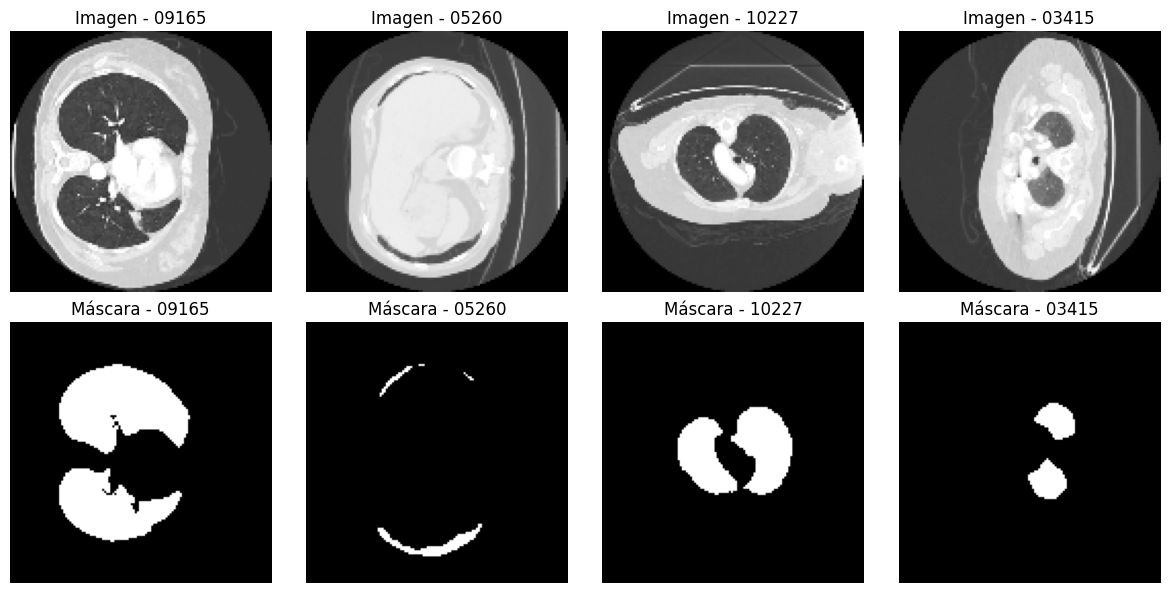

In [21]:
images, masks, infos = next(iter(train_loader))

num_examples = min(4, images.shape[0])

plt.figure(figsize=(12, 6))
for i in range(num_examples):
    # La imagen está en formato [1, H, W], convertimos a [H, W]
    img = images[i].squeeze().cpu().numpy()
    mask = masks[i].squeeze().cpu().numpy()

    # Mostrar imagen
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Imagen - {infos['img_id'][i]}")
    plt.axis('off')

    # Mostrar máscara
    plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Máscara - {infos['img_id'][i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
try:
  sample_batch = next(iter(train_loader))
  print(f"   ✅ Batch de prueba exitoso - Forma: {sample_batch[0].shape}")
except Exception as e:
  print(f"   ❌ Error en batch de prueba: {e}")

   ✅ Batch de prueba exitoso - Forma: torch.Size([16, 1, 128, 128])


In [23]:
def train_epoch(config, train_loader, model, criterion, optimizer, epoch):
  """Entrena el modelo por una época"""
  avg_meters = {'loss': AverageMeter(), 'iou': AverageMeter()}
  
  model.train()
  pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch}')
  
  # Gradient accumulation
  accumulation_steps = max(1, config['accumulation_steps'] // config['batch_size'])
  optimizer.zero_grad()
  
  for i, (input, target, *_) in enumerate(train_loader):
    input = input.cuda()
    target = target.cuda()
    
    # Normalizar target si es necesario
    if target.max() > 1.0:
      target = target.float() / 255.0
    
    # Forward pass
    if config['deep_supervision']:
      outputs = model(input)
      loss = 0
      for j, output in enumerate(outputs):
        weight = 1.0 / (2 ** j)
        loss += weight * criterion(output, target)
      loss /= sum([1.0 / (2 ** j) for j in range(len(outputs))])
      iou = iou_score(outputs[-1], target)
    else:
      output = model(input)
      loss = criterion(output, target)
      iou = iou_score(output, target)
    
    loss = loss / accumulation_steps
    loss.backward()
    
    if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
      optimizer.step()
      optimizer.zero_grad()
    
    avg_meters['loss'].update(loss.item() * accumulation_steps, input.size(0))
    avg_meters['iou'].update(iou, input.size(0))
    
    pbar.set_postfix({
      'loss': f"{avg_meters['loss'].avg:.4f}",
      'iou': f"{avg_meters['iou'].avg:.4f}"
    })
    pbar.update(1)
  
  pbar.close()
  return OrderedDict([('loss', avg_meters['loss'].avg), ('iou', avg_meters['iou'].avg)])

def validate_epoch(config, val_loader, model, criterion):
  """Valida el modelo"""
  avg_meters = {'loss': AverageMeter(), 'iou': AverageMeter()}
  
  model.eval()
  
  with torch.no_grad():
    pbar = tqdm(total=len(val_loader), desc='Validation')
    for input, target, *_ in val_loader:
      input = input.cuda()
      target = target.cuda()
      
      if target.max() > 1.0:
        target = target / 255.0
      
      if config['deep_supervision']:
        outputs = model(input)
        loss = 0
        for output in outputs:
          loss += criterion(output, target)
        loss /= len(outputs)
        iou = iou_score(outputs[-1], target)
      else:
        output = model(input)
        loss = criterion(output, target)
        iou = iou_score(output, target)
      
      avg_meters['loss'].update(loss.item(), input.size(0))
      avg_meters['iou'].update(iou, input.size(0))
      
      pbar.set_postfix({
        'val_loss': f"{avg_meters['loss'].avg:.4f}",
        'val_iou': f"{avg_meters['iou'].avg:.4f}"
      })
      pbar.update(1)
    pbar.close()
  
  return OrderedDict([('loss', avg_meters['loss'].avg), ('iou', avg_meters['iou'].avg)])

print("✅ Funciones de entrenamiento y validación definidas")

✅ Funciones de entrenamiento y validación definidas


In [24]:
def plot_training_progress(log, save_path=None):
  """Visualiza el progreso del entrenamiento"""
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
  
  epochs = log['epoch']
  
  # Loss
  ax1.plot(epochs, log['loss'], 'b-', label='Train Loss', linewidth=2)
  ax1.plot(epochs, log['val_loss'], 'r-', label='Val Loss', linewidth=2)
  ax1.set_title('Training and Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.grid(True, alpha=0.3)
  
  # IoU
  ax2.plot(epochs, log['iou'], 'b-', label='Train IoU', linewidth=2)
  ax2.plot(epochs, log['val_iou'], 'r-', label='Val IoU', linewidth=2)
  ax2.set_title('Training and Validation IoU')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('IoU')
  ax2.legend()
  ax2.grid(True, alpha=0.3)
  
  # Learning Rate
  ax3.plot(epochs, log['lr'], 'g-', linewidth=2)
  ax3.set_title('Learning Rate Schedule')
  ax3.set_xlabel('Epoch')
  ax3.set_ylabel('Learning Rate')
  ax3.set_yscale('log')
  ax3.grid(True, alpha=0.3)
  
  # Overfitting Detection
  iou_gap = [train - val for train, val in zip(log['iou'], log['val_iou'])]
  ax4.plot(epochs, iou_gap, 'purple', linewidth=2)
  ax4.axhline(y=0.08, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
  ax4.set_title('Overfitting Detection (Train IoU - Val IoU)')
  ax4.set_xlabel('Epoch')
  ax4.set_ylabel('IoU Gap')
  ax4.legend()
  ax4.grid(True, alpha=0.3)
  
  plt.tight_layout()
  
  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
  
  plt.show()

print("✅ Función de visualización definida")

✅ Función de visualización definida


In [25]:
log = OrderedDict([
  ('epoch', []),
  ('lr', []),
  ('loss', []),
  ('iou', []),
  ('val_loss', []),
  ('val_iou', []),
])

best_iou = 0
early_stopping = EarlyStopping(patience=config['early_stopping'], min_delta=0.001)

print("🚀 INICIANDO ENTRENAMIENTO")
print("=" * 60)

🚀 INICIANDO ENTRENAMIENTO



📅 Época [1/100]


Validation: 100%|██████████| 229/229 [00:12<00:00, 18.05it/s, val_loss=0.8240, val_iou=0.1595]


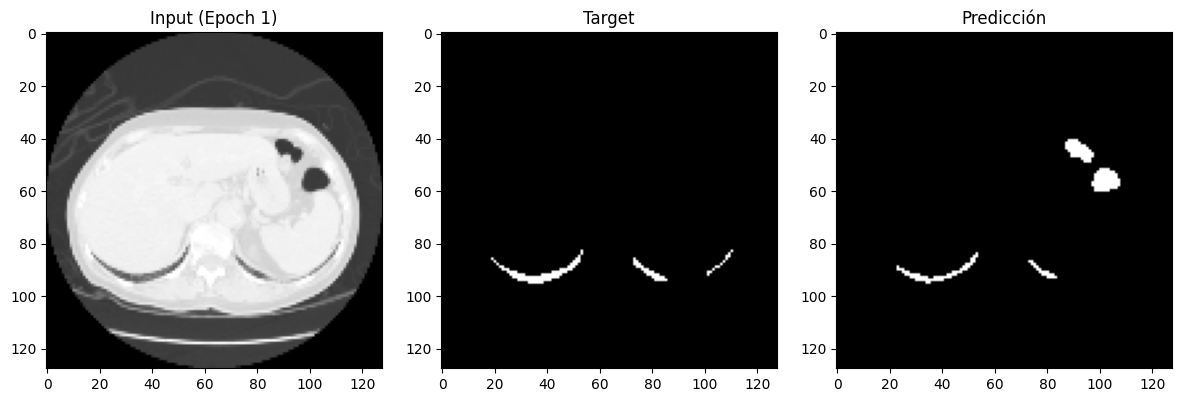

📊 Loss: 0.2039 | IoU: 0.8306 | Val Loss: 0.8240 | Val IoU: 0.1595 | LR: 5.00e-04
⚠️  OVERFITTING DETECTADO - IoU gap: 0.6711, Loss gap: 0.6201
📉 Learning rate reducido a: 0.000250
💾 Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.1595)
📁 Modelo de la época 1 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_1.pth

📅 Época [2/100]


Validation: 100%|██████████| 229/229 [00:10<00:00, 21.94it/s, val_loss=0.0878, val_iou=0.9157]


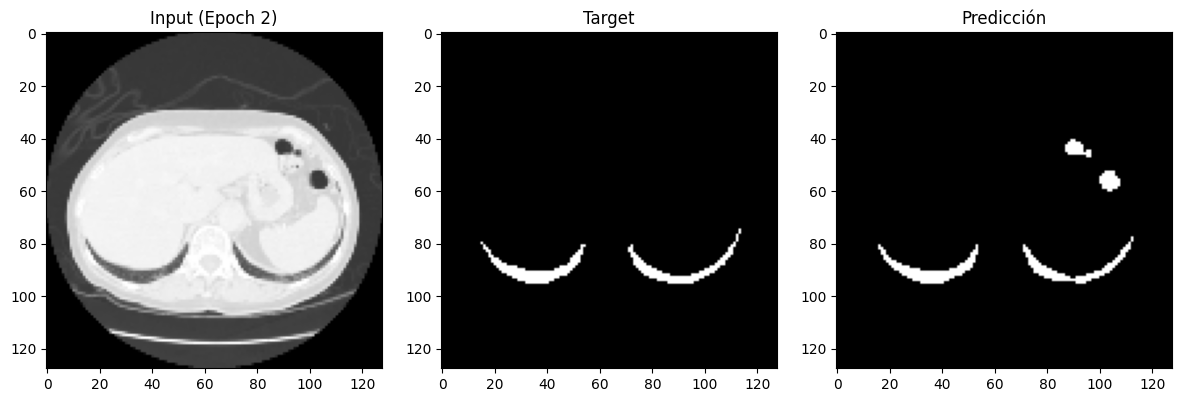

📊 Loss: 0.0717 | IoU: 0.8967 | Val Loss: 0.0878 | Val IoU: 0.9157 | LR: 2.50e-04
💾 Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.9157)
📁 Modelo de la época 2 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_2.pth

📅 Época [3/100]


Validation: 100%|██████████| 229/229 [00:11<00:00, 20.65it/s, val_loss=0.1070, val_iou=0.9163]


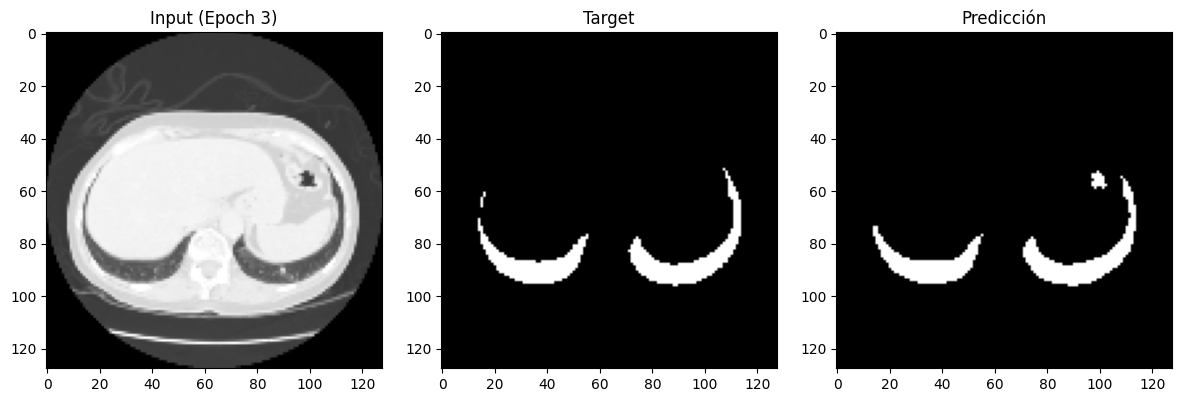

📊 Loss: 0.0647 | IoU: 0.8979 | Val Loss: 0.1070 | Val IoU: 0.9163 | LR: 2.49e-04
💾 Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.9163)
📁 Modelo de la época 3 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_3.pth

📅 Época [4/100]


Validation: 100%|██████████| 229/229 [00:10<00:00, 21.27it/s, val_loss=0.1159, val_iou=0.9215]


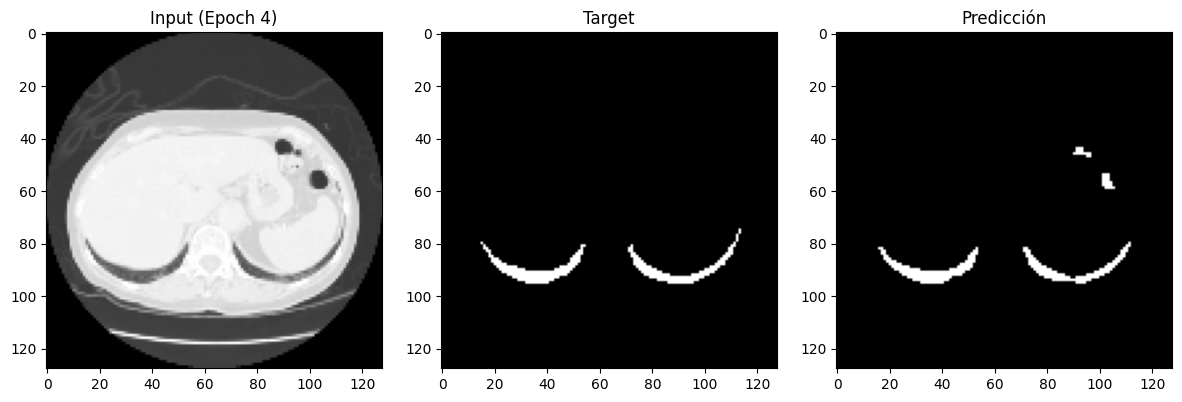

📊 Loss: 0.0716 | IoU: 0.8930 | Val Loss: 0.1159 | Val IoU: 0.9215 | LR: 2.49e-04
💾 Mejor modelo guardado en models/processed_data_512_NestedUNet_binary_wDS/best_model.pth (IoU: 0.9215)
📁 Modelo de la época 4 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_4.pth

📅 Época [5/100]


Validation: 100%|██████████| 229/229 [00:11<00:00, 20.46it/s, val_loss=0.1611, val_iou=0.9014]


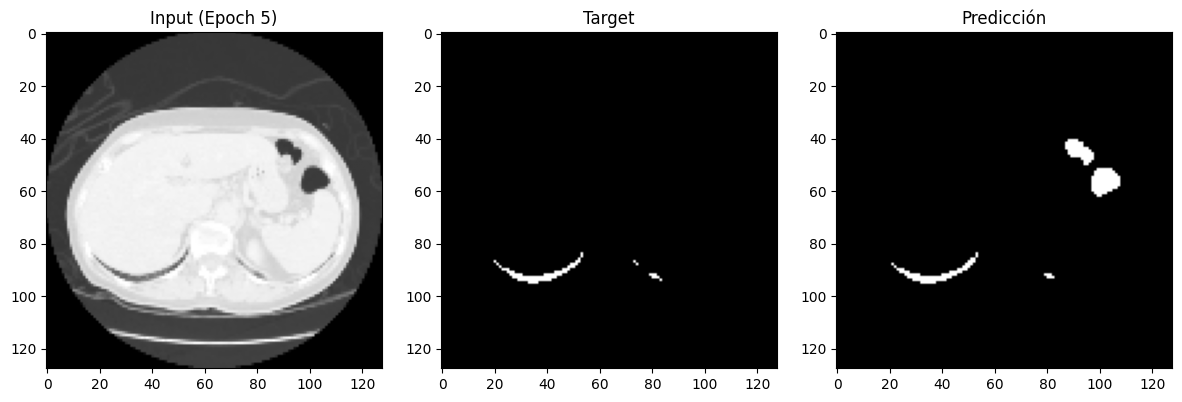

📊 Loss: 0.0848 | IoU: 0.8867 | Val Loss: 0.1611 | Val IoU: 0.9014 | LR: 2.48e-04
📁 Modelo de la época 5 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_5.pth

📅 Época [6/100]


Validation: 100%|██████████| 229/229 [00:12<00:00, 18.99it/s, val_loss=0.1615, val_iou=0.9040]


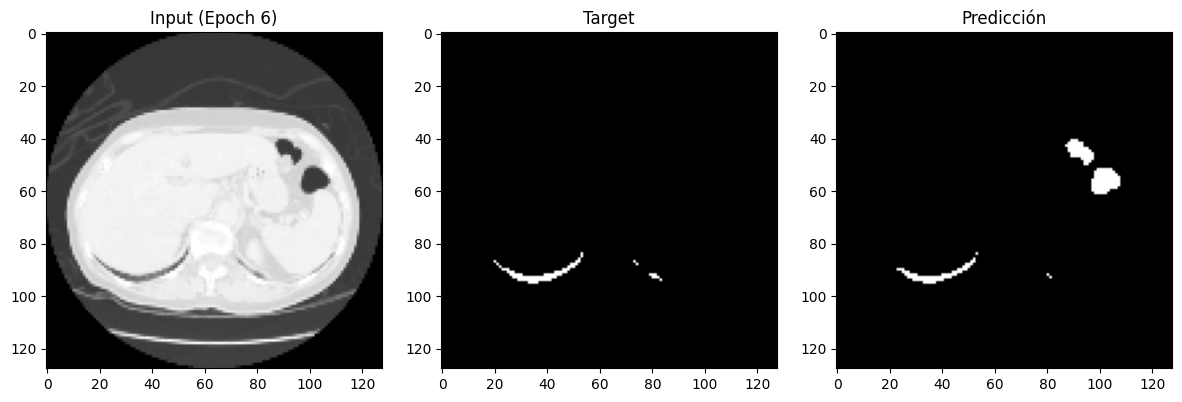

📊 Loss: 0.0994 | IoU: 0.8817 | Val Loss: 0.1615 | Val IoU: 0.9040 | LR: 2.48e-04
📁 Modelo de la época 6 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_6.pth

📅 Época [7/100]


Validation: 100%|██████████| 229/229 [00:12<00:00, 19.03it/s, val_loss=0.1512, val_iou=0.9033]


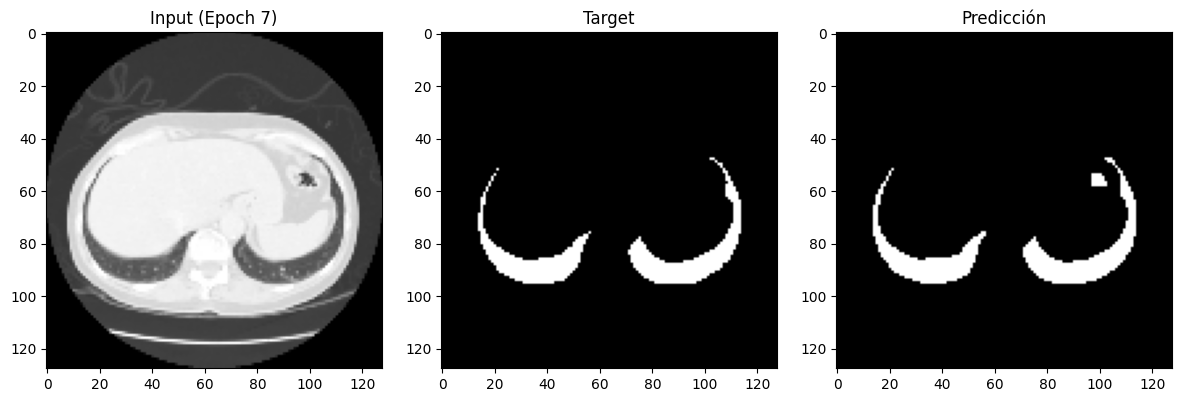

📊 Loss: 0.1046 | IoU: 0.8804 | Val Loss: 0.1512 | Val IoU: 0.9033 | LR: 2.47e-04
📁 Modelo de la época 7 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_7.pth

📅 Época [8/100]


Validation: 100%|██████████| 229/229 [00:11<00:00, 19.16it/s, val_loss=0.1632, val_iou=0.8959]


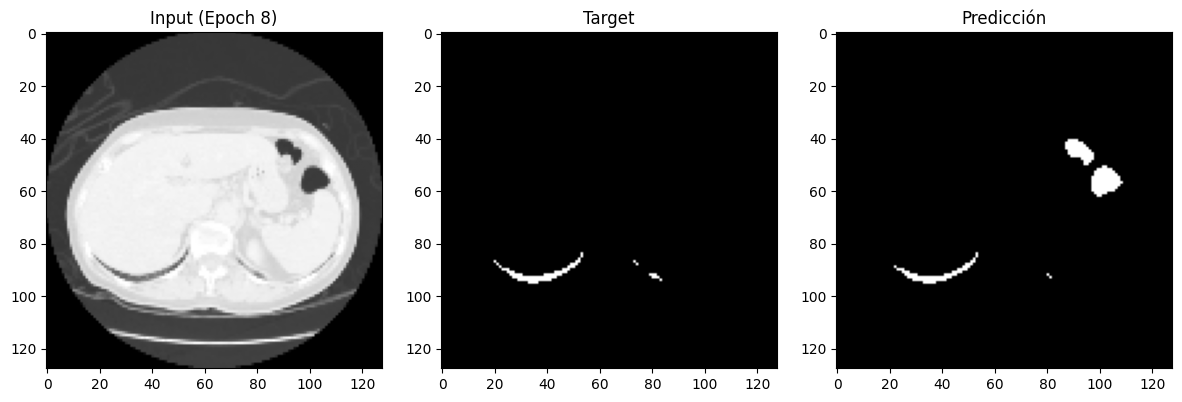

📊 Loss: 0.1091 | IoU: 0.8806 | Val Loss: 0.1632 | Val IoU: 0.8959 | LR: 2.46e-04
📁 Modelo de la época 8 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_8.pth

📅 Época [9/100]


Validation: 100%|██████████| 229/229 [00:11<00:00, 19.21it/s, val_loss=0.1587, val_iou=0.8934]


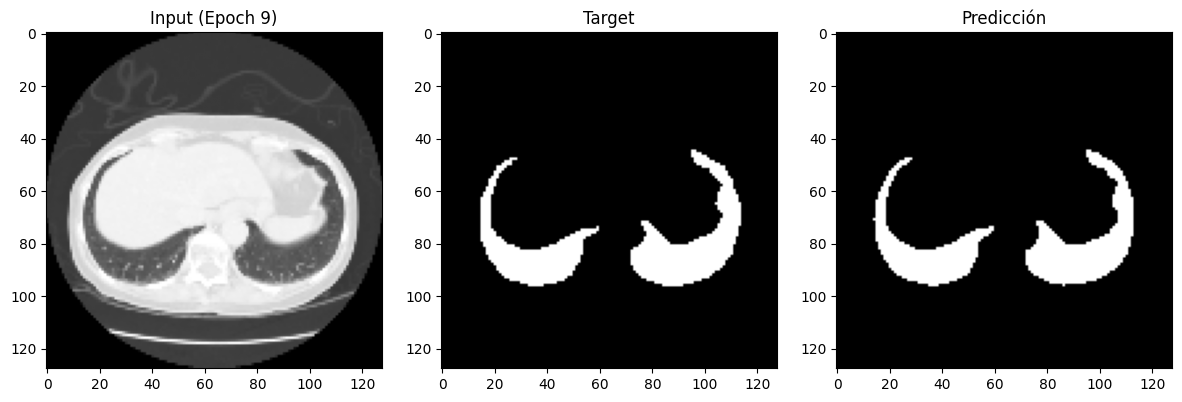

📊 Loss: 0.1059 | IoU: 0.8806 | Val Loss: 0.1587 | Val IoU: 0.8934 | LR: 2.45e-04
📁 Modelo de la época 9 guardado en models/processed_data_512_NestedUNet_binary_wDS/checkpoints/model_epoch_9.pth
🛑 Early stopping activado

🎉 Entrenamiento completado hasta época 8
🏆 Mejor IoU alcanzado: 0.9215


In [26]:
EPOCHS_TO_RUN = 100  # Cambia esto para entrenar más épocas

current_epoch = len(log['epoch'])
end_epoch = min(current_epoch + EPOCHS_TO_RUN, config['epochs'])

for epoch in range(current_epoch, end_epoch):
  print(f'\n📅 Época [{epoch + 1}/{config["epochs"]}]')
  
  # Entrenamiento
  train_log = train_epoch(config, train_loader, model, criterion, optimizer, epoch)
  
  # Validación
  val_log = validate_epoch(config, val_loader, model, criterion)
  
  model.eval()
  with torch.no_grad():
    sample = next(iter(val_loader))
    input, target = sample[0].cuda(), sample[1].cuda()
    output = model(input)

    if isinstance(output, list):
        output = output[-1]

    output = torch.sigmoid(output)
    pred = (output > 0.5).float()

    idx = random.randint(0, input.size(0) - 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.imshow(input[idx, 0].cpu(), cmap='gray')
  plt.title(f'Input (Epoch {epoch + 1})')

  plt.subplot(1, 3, 2)
  plt.imshow(target[idx, 0].cpu(), cmap='gray')
  plt.title('Target')

  plt.subplot(1, 3, 3)
  plt.imshow(pred[idx, 0].cpu(), cmap='gray')
  plt.title('Predicción')
  plt.tight_layout()
  plt.show()

  # Actualizar scheduler
  if config['scheduler'] == 'CosineAnnealingLR':
    scheduler.step()
  elif config['scheduler'] == 'ReduceLROnPlateau':
    scheduler.step(val_log['loss'])
  
  # Mostrar resultados
  current_lr = optimizer.param_groups[0]['lr']
  print(f'📊 Loss: {train_log["loss"]:.4f} | IoU: {train_log["iou"]:.4f} | '
        f'Val Loss: {val_log["loss"]:.4f} | Val IoU: {val_log["iou"]:.4f} | LR: {current_lr:.2e}')
  
  # Detección temprana de overfitting
  overfitting_gap = train_log['iou'] - val_log['iou']
  loss_gap = val_log['loss'] - train_log['loss']
  
  if overfitting_gap > 0.08 and loss_gap > 0.1:
    print(f'⚠️  OVERFITTING DETECTADO - IoU gap: {overfitting_gap:.4f}, Loss gap: {loss_gap:.4f}')
    for param_group in optimizer.param_groups:
      param_group['lr'] *= 0.5
    print(f'📉 Learning rate reducido a: {optimizer.param_groups[0]["lr"]:.6f}')
  
  # Actualizar log
  log['epoch'].append(epoch)
  log['lr'].append(current_lr)
  log['loss'].append(train_log['loss'])
  log['iou'].append(train_log['iou'])
  log['val_loss'].append(val_log['loss'])
  log['val_iou'].append(val_log['iou'])
  
  # Guardar log
  pd.DataFrame(log).to_csv(f'models/{config["name"]}/log.csv', index=False)
  
  # Guardar mejor modelo
  if val_log['iou'] > best_iou:
    best_iou = val_log['iou']
    best_model_path = f'models/{config["name"]}/best_model.pth'
    torch.save(model.state_dict(), best_model_path)
    print(f'💾 Mejor modelo guardado en {best_model_path} (IoU: {best_iou:.4f})')

  # Guardar modelo de esta época
  epoch_model_path = f'models/{config["name"]}/checkpoints/model_epoch_{epoch + 1}.pth'
  os.makedirs(os.path.dirname(epoch_model_path), exist_ok=True)
  torch.save(model.state_dict(), epoch_model_path)
  print(f'📁 Modelo de la época {epoch + 1} guardado en {epoch_model_path}')
  
  # Early stopping
  if early_stopping(val_log['iou'], model):
    print("🛑 Early stopping activado")
    break
  
  # Limpiar memoria
  torch.cuda.empty_cache()

print(f"\n🎉 Entrenamiento completado hasta época {epoch}")
print(f"🏆 Mejor IoU alcanzado: {best_iou:.4f}")

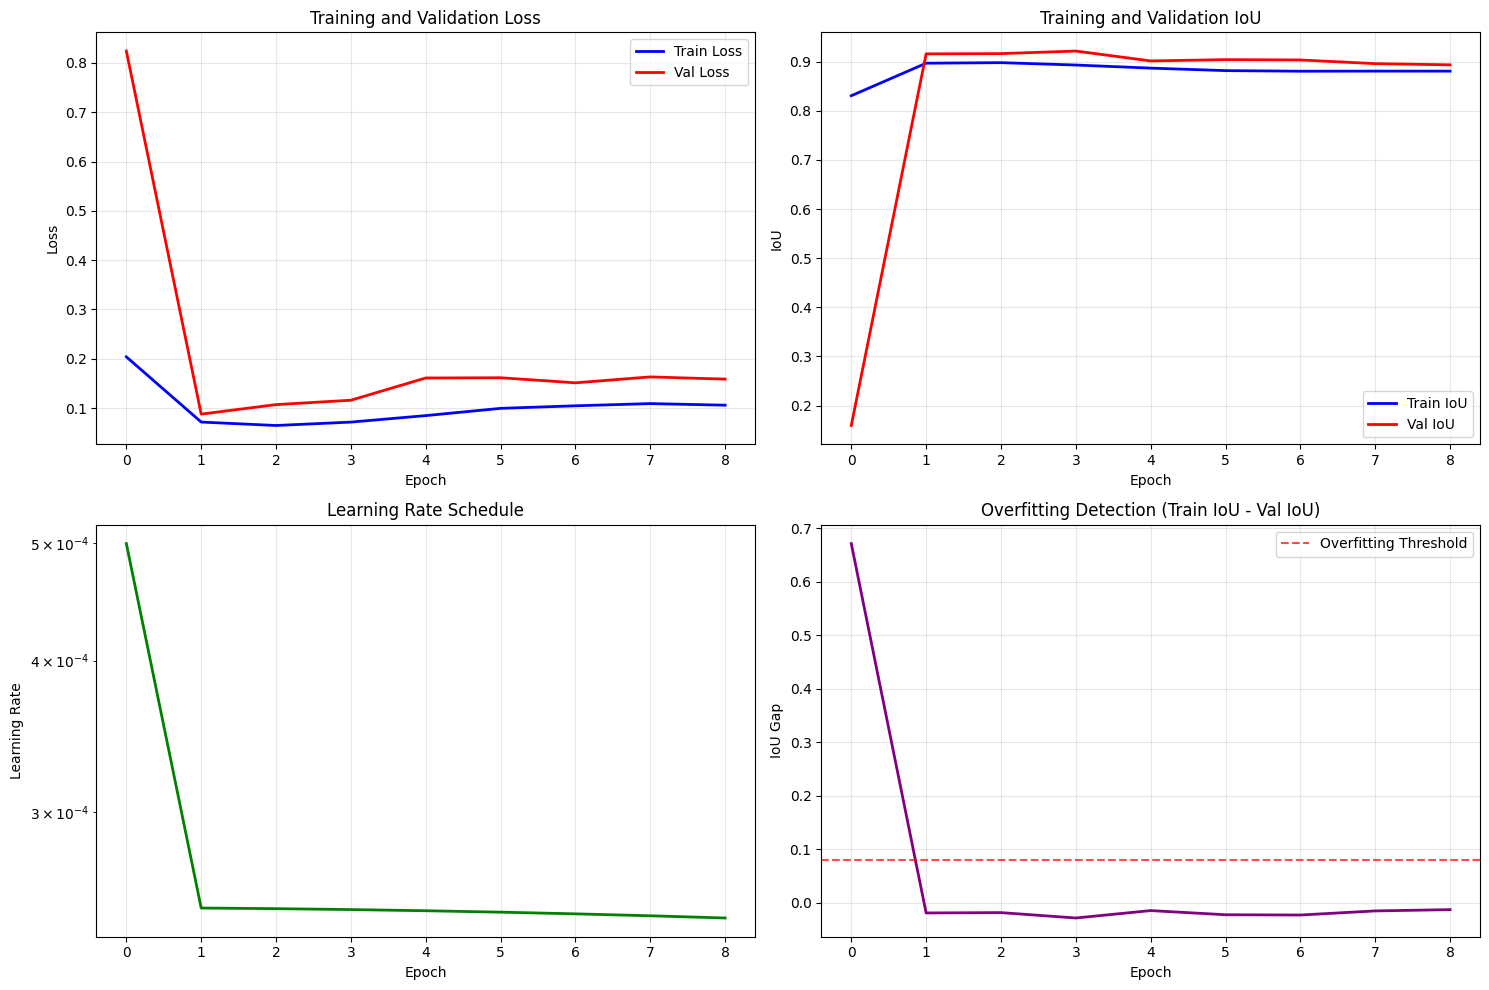

📈 ESTADÍSTICAS DEL ENTRENAMIENTO:
----------------------------------------
Épocas completadas: 9
Mejor IoU: 0.9215
Menor Loss de validación: 0.0878
IoU actual: 0.8934
Loss actual: 0.1587
Tendencia reciente: 📉 Empeorando


In [27]:
if len(log['epoch']) > 0:
  plot_training_progress(log, f'models/{config["name"]}/training_progress.png')
  
  # Mostrar estadísticas actuales
  print("📈 ESTADÍSTICAS DEL ENTRENAMIENTO:")
  print("-" * 40)
  print(f"Épocas completadas: {len(log['epoch'])}")
  print(f"Mejor IoU: {max(log['val_iou']):.4f}")
  print(f"Menor Loss de validación: {min(log['val_loss']):.4f}")
  print(f"IoU actual: {log['val_iou'][-1]:.4f}")
  print(f"Loss actual: {log['val_loss'][-1]:.4f}")
  
  # Detectar tendencias
  if len(log['val_iou']) >= 3:
    recent_trend = np.mean(log['val_iou'][-3:]) - np.mean(log['val_iou'][-6:-3]) if len(log['val_iou']) >= 6 else 0
    print(f"Tendencia reciente: {'📈 Mejorando' if recent_trend > 0 else '📉 Empeorando' if recent_trend < 0 else '➡️ Estable'}")
else:
  print("⚠️ No hay datos de entrenamiento para visualizar. Ejecuta el bloque de entrenamiento primero.")

In [28]:
def save_checkpoint(model, optimizer, scheduler, epoch, best_iou, log, filename):
  """Guardar checkpoint completo"""
  checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
    'best_iou': best_iou,
    'log': log,
    'config': config
  }
  torch.save(checkpoint, filename)
  print(f"💾 Checkpoint guardado: {filename}")

def load_checkpoint(filename, model, optimizer, scheduler=None):
  """Cargar checkpoint completo"""
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  if scheduler and checkpoint['scheduler_state_dict']:
      scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  
  return (checkpoint['epoch'], checkpoint['best_iou'], 
          checkpoint['log'], checkpoint['config'])

In [29]:
if len(log['epoch']) > 0:
  checkpoint_path = f'models/{config["name"]}/checkpoint_epoch_{len(log["epoch"])}.pth'
  save_checkpoint(model, optimizer, scheduler, len(log['epoch']), best_iou, log, checkpoint_path)

print("✅ Funciones de checkpoint definidas")

💾 Checkpoint guardado: models/processed_data_512_NestedUNet_binary_wDS/checkpoint_epoch_9.pth
✅ Funciones de checkpoint definidas


In [30]:
def print_final_summary():
  """Imprime un resumen final del entrenamiento"""
  if len(log['epoch']) == 0:
    print("⚠️ No hay datos de entrenamiento para resumir")
    return
  
  print("\n" + "="*60)
  print("🎯 RESUMEN FINAL DEL ENTRENAMIENTO")
  print("="*60)
  
  print(f"📊 Configuración:")
  print(f"   • Modelo: {config['arch']}")
  print(f"   • Función de pérdida: {config['loss']}")
  print(f"   • Optimizador: {config['optimizer']} (LR: {config['lr']})")
  print(f"   • Batch size: {config['batch_size']}")
  print(f"   • Early stopping: {config['early_stopping']} épocas")
  
  print(f"\n📈 Resultados:")
  print(f"   • Épocas completadas: {len(log['epoch'])}/{config['epochs']}")
  print(f"   • Mejor IoU: {max(log['val_iou']):.4f}")
  print(f"   • IoU final: {log['val_iou'][-1]:.4f}")
  print(f"   • Mejor Loss validación: {min(log['val_loss']):.4f}")
  print(f"   • Loss final: {log['val_loss'][-1]:.4f}")
  
  # Análisis de overfitting
  final_gap = log['iou'][-1] - log['val_iou'][-1]
  print(f"\n🔍 Análisis de Overfitting:")
  print(f"   • Gap IoU (Train-Val): {final_gap:.4f}")
  if final_gap > 0.08:
    print(f"   • ⚠️ Posible overfitting detectado")
  else:
    print(f"   • ✅ Nivel de overfitting aceptable")
  
  # Tendencia de mejora
  if len(log['val_iou']) >= 5:
    recent_iou = np.mean(log['val_iou'][-3:])
    early_iou = np.mean(log['val_iou'][:3])
    improvement = recent_iou - early_iou
    print(f"\n📊 Mejora Total:")
    print(f"   • IoU inicial: {early_iou:.4f}")
    print(f"   • IoU reciente: {recent_iou:.4f}")
    print(f"   • Mejora: {improvement:.4f} ({improvement/early_iou*100:.1f}%)")
  
  print(f"\n💾 Archivos guardados:")
  print(f"   • Modelo: models/{config['name']}/model.pth")
  print(f"   • Log: models/{config['name']}/log.csv")
  print(f"   • Config: models/{config['name']}/config.yml")
  print(f"   • Gráficas: models/{config['name']}/training_progress.png")
  
  print("="*60)

# Ejecutar resumen si hay datos
print_final_summary()


🎯 RESUMEN FINAL DEL ENTRENAMIENTO
📊 Configuración:
   • Modelo: NestedUNet
   • Función de pérdida: TverskyLoss
   • Optimizador: Adam (LR: 0.0005)
   • Batch size: 16
   • Early stopping: 5 épocas

📈 Resultados:
   • Épocas completadas: 9/100
   • Mejor IoU: 0.9215
   • IoU final: 0.8934
   • Mejor Loss validación: 0.0878
   • Loss final: 0.1587

🔍 Análisis de Overfitting:
   • Gap IoU (Train-Val): -0.0128
   • ✅ Nivel de overfitting aceptable

📊 Mejora Total:
   • IoU inicial: 0.6638
   • IoU reciente: 0.8975
   • Mejora: 0.2337 (35.2%)

💾 Archivos guardados:
   • Modelo: models/processed_data_512_NestedUNet_binary_wDS/model.pth
   • Log: models/processed_data_512_NestedUNet_binary_wDS/log.csv
   • Config: models/processed_data_512_NestedUNet_binary_wDS/config.yml
   • Gráficas: models/processed_data_512_NestedUNet_binary_wDS/training_progress.png
